In [1]:
## Lidar autocovariance function

In [148]:
import xarray as xr
import numpy as np
from scipy.signal import periodogram
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['fft']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
acf_ds = xarray.open_dataset('sgpdlacfC1.a1.20170630.201048.nc.v0')

In [4]:
acf_ds

<xarray.Dataset>
Dimensions:      (complex: 2, nlags: 20, nsamples: 4000, time: 169)
Coordinates:
  * time         (time) datetime64[ns] 2017-06-30T20:10:48.380000 ... 2017-06-30T20:16:01.580000
  * complex      (complex) int16 1 2
  * nlags        (nlags) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Dimensions without coordinates: nsamples
Data variables:
    base_time    datetime64[ns] ...
    time_offset  (time) datetime64[ns] ...
    azimuth      (time) float32 ...
    elevation    (time) float32 ...
    acf_bkg      (nsamples, nlags, complex) float32 ...
    acf          (time, nsamples, nlags, complex) float32 ...
    lat          float32 ...
    lon          float32 ...
    alt          float32 ...
Attributes:
    command_line:          dlacf_ingest -s sgp -f C1 -D
    Conventions:           ARM-1.2
    process_version:       ingest-dlacf-1.0-0.el6
    dod_version:           dlacf-a1-1.0
    input_source:          /data/collection/sgp/sgpdlacfC1.00/aet_Stare_107_2...


In [5]:
my_spectra = acf_ds['acf'].isel(time=0)
my_spectra

<xarray.DataArray 'acf' (nsamples: 4000, nlags: 20, complex: 2)>
[160000 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 2017-06-30T20:10:48.380000
  * complex  (complex) int16 1 2
  * nlags    (nlags) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Dimensions without coordinates: nsamples
Attributes:
    long_name:  Complex autocovariance function
    units:      1

In [6]:
my_spectra

<xarray.DataArray 'acf' (nsamples: 4000, nlags: 20, complex: 2)>
[160000 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 2017-06-30T20:10:48.380000
  * complex  (complex) int16 1 2
  * nlags    (nlags) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Dimensions without coordinates: nsamples
Attributes:
    long_name:  Complex autocovariance function
    units:      1

In [7]:
np.fft.ifft?

In [161]:
def get_psd(spectra):
    complex_coeff = spectra['acf'].sel(complex=1).values + spectra['acf'].sel(complex=2).values * 1j
    freq, power = periodogram(complex_coeff, axis=2, fs=50e6)
    #fft =  np.fft.fft(complex_coeff, axis=2)
    #freq = np.fft.fftfreq(20, d=1/(50.*1e6))
    inds_sorted = np.argsort(freq)
    #print(fft.shape)
    spectra['power'] = xr.DataArray(power[:, :, inds_sorted], dims=(('time', 'nsamples', 'nlags')))
    spectra['freq_bins'] = xr.DataArray(freq[inds_sorted], dims=['nlags'])
    return spectra

In [162]:
my_spectra = get_psd(acf_ds)
coeff.shape
tau_s = 1/(50*1e6)
frequency = 2*np.pi*np.arange(-10, 10)/(20*tau_s)
c = 299792458.
frequency

array([-1.57079633e+08, -1.41371669e+08, -1.25663706e+08, -1.09955743e+08,
       -9.42477796e+07, -7.85398163e+07, -6.28318531e+07, -4.71238898e+07,
       -3.14159265e+07, -1.57079633e+07,  0.00000000e+00,  1.57079633e+07,
        3.14159265e+07,  4.71238898e+07,  6.28318531e+07,  7.85398163e+07,
        9.42477796e+07,  1.09955743e+08,  1.25663706e+08,  1.41371669e+08])

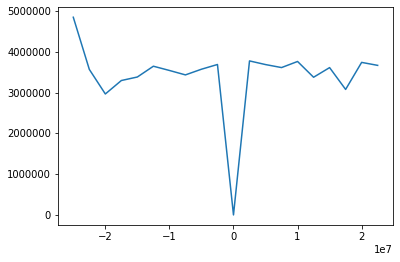

In [168]:
plt.plot(my_spectra['freq_bins'], my_spectra['power'].isel(time=50, nsamples=310))

In [128]:
my_spectra['fft'].real

<xarray.DataArray 'fft' (time: 169, nsamples: 4000, nlags: 20)>
array([[[ 4148978. ,  4099360. ,  3999872.2, ...,  4450910.5,
          4379962. ,  4226745. ],
        [ 3938983.2,  4010216. ,  4150323.2, ...,  3968207.8,
          3823456.8,  3850719. ],
        [ 4278446. ,  4179834.2,  3998567. , ...,  3784558. ,
          4128969.5,  4320687. ],
        ...,
        [68258720. , 60806428. , 58962496. , ..., 61330576. ,
         59493744. , 62045864. ],
        [68189120. , 56757812. , 57331380. , ..., 59036620. ,
         59591412. , 64339440. ],
        [72035210. , 59557588. , 57999660. , ..., 56431896. ,
         59243428. , 65296864. ]],

       [[ 4460633. ,  4462012. ,  4618914.5, ...,  4871949. ,
          4793800.5,  4637354.5],
        [ 4173476.5,  4115621. ,  3880289.2, ...,  4485458. ,
          4115519.8,  4033849.5],
        [ 4256487. ,  4365199. ,  4583067. , ...,  3437130.5,
          3934703.2,  4281293. ],
        ...,
        [67542750. , 58743820. , 58419040. ,